### Домашнее задание №10 по теме «Поиск выбросов и генерация новых признаков»

In [1]:
import pandas as pd
import numpy as np
from random import sample
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.3f}'.format

### Задание  
 __Цель:__ Изучить применение методов по поиску выбросов в данных, попрактиковаться в обработке экстремальных значений.  
 __Описание задания:__
В домашнем задании нужно решить задачу классификации типа стекол. Данные для обучения моделей можно скачать с сайта. Целевая переменная – тип стекла «Type». Остальные признаки описывают химические элементы в составе материала. Датасет нужно исследовать на наличие выбросов, провести EDA.
 __Этапы работы:__. 

1. Получите данные и загрузите их в рабочую среду.  
2. Проведите первичный анализ.  
    а. Проверьте количество записей для каждого класса. Сделайте вывод.  
3. Разделите выборку на обучающее и тестовое подмножество. 80% данных оставить на обучающее множество, 20% на тестовое.  
4. Обучите модель дерева решений `RandomForestClassifier` на обучающем множестве.  
5. Для тестового множества предскажите тип стекла и сравните с истинным значением, посчитав точность предсказания модели (`accuracy`).
6. Обработайте выбросы в данных.  
    а. Визуализируйте распределение значений для каждой переменной. Можно использовать функции `sns.boxplot`, `sns.distplot`. Есть ли признаки с нормальным распределением?  
    b. Исследуйте признаки на выбросы несколькими способами.  
    c. Удалите выбросы. \*Посчитайте процент удаленных записей от общего числа записей для каждого класса.  
7. Повторите п. 4, п. 5.
8. Сформулируйте выводы по проделанной работе.
    а. Кратко опишите, какие преобразования были сделаны с данными.  
    b. Сравните точность двух моделей.  
    c. Напишите свое мнение, нужно ли исследовать данные на выбросы, для чего это делается, плюсы и минусы подхода.
 _____
Для получения зачета по этому домашнему заданию минимально должны быть реализованы методы по поиску выбросов и построены две модели: «до» и «после» обработки экстремальных значений.  



#### 1. Загружаем данные

In [2]:
glass_raw = pd.read_csv('Downloads/glass.csv')

In [3]:
glass_raw.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.521,13.640,4.490,1.100,71.780,0.060,8.750,0.000,0.000,1
1,1.518,13.890,3.600,1.360,72.730,0.480,7.830,0.000,0.000,1
2,1.516,13.530,3.550,1.540,72.990,0.390,7.780,0.000,0.000,1
3,1.518,13.210,3.690,1.290,72.610,0.570,8.220,0.000,0.000,1
4,1.517,13.270,3.620,1.240,73.080,0.550,8.070,0.000,0.000,1


#### 2. EDA

In [4]:
glass_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


In [5]:
glass_raw.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000,214.000,214.000,214.000,214.000,214.000,214.000,214.000,214.000,214.000
mean,1.518,13.408,2.685,1.445,72.651,0.497,8.957,0.175,0.057,2.780
std,0.003,0.817,1.442,0.499,0.775,0.652,1.423,0.497,0.097,2.104
min,1.511,10.730,0.000,0.290,69.810,0.000,5.430,0.000,0.000,1.000
5%,1.515,12.415,0.000,0.696,71.315,0.000,7.812,0.000,0.000,1.000
25%,1.517,12.908,2.115,1.190,72.280,0.122,8.240,0.000,0.000,1.000
50%,1.518,13.300,3.480,1.360,72.790,0.555,8.600,0.000,0.000,2.000
75%,1.519,13.825,3.600,1.630,73.088,0.610,9.172,0.000,0.100,3.000
95%,1.524,14.854,3.850,2.394,73.517,0.760,11.561,1.570,0.267,7.000
max,1.534,17.380,4.490,3.500,75.410,6.210,16.190,3.150,0.510,7.000


In [6]:
pd.concat(
    [
        glass_raw.Type.value_counts().rename('cnt'), 
        round((glass_raw.Type.value_counts().rename('cnt') / glass_raw.Type.count() * 100),2).rename('%')
    ], axis=1)

,cnt,%
2,76,35.510
1,70,32.710
7,29,13.550
3,17,7.940
5,13,6.070
6,9,4.210


1. Данных не много, всего 214 строк.  
2. Все признаки количественные.  
3. Пропусков нет.  
4. В ЦП 6 классов, Разбалансированны.  
5. Выбросы по всей видимости есть. 
6. На распределения посмотрим дальше на графиках.

#### 3. Разделяем выборки

In [7]:
X, y = glass_raw.drop(columns='Type', axis=1),glass_raw['Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((171, 9), (43, 9))

#### 4. Обучаем модель дерева решений

In [8]:
model = RandomForestClassifier(
    n_estimators=40,
    max_features=9,
    max_samples=.5,
    class_weight='balanced',
    random_state=1)

model.fit(X_train.values, y_train)
y_pred_train = model.predict(X_train.values)
y_pred_test = model.predict(X_test.values)
accuracy_train = model.score(X_train.values, y_train)
accuracy_test = model.score(X_test.values, y_test)
print('Accuracy train:', accuracy_train)
print('Accuracy test:', accuracy_test)

Accuracy train: 0.9590643274853801
Accuracy test: 0.813953488372093


Дальше будем использовать функцию и собирать метрики в датафрейм

In [9]:
def get_score_df(df, target, random_seed=42, model=None, title='dtc_default'):
    if model is None:
        model = RandomForestClassifier(random_state=random_seed)
    
    X = df.drop([target], axis = 1)
    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed) 


    model.fit(X_train.values, y_train)
    y_pred_train = model.predict(X_train.values)
    y_pred_test = model.predict(X_test.values)
    

    accuracy_train = model.score(X_train.values, y_train)
    accuracy_test = model.score(X_test.values, y_test)

    metrix = {}
    metrix['accuracy_train'] = accuracy_train
    metrix['accuracy_test'] = accuracy_test

    res = pd.DataFrame.from_dict(metrix, orient='index', columns=[title])
    
    return res

In [10]:
res = pd.DataFrame()

In [11]:
res_0 = get_score_df(glass_raw, 'Type', model=RandomForestClassifier(
    n_estimators=40,
    max_features=9,
    max_samples=.5,
    class_weight='balanced',
    random_state=1), title='rfc_raw')
res = pd.concat([res, res_0], axis=1)
res.T

,accuracy_train,accuracy_test
rfc_raw,0.959,0.814


Если ничего не делать с данными, а лишь подобрать некоторые параметры получим такую метрику, при этом модель переучивается

#### 5. Для тестового множества предсказываем тип стекла

In [12]:
pd.concat([
    X_test.reset_index(drop=True), 
    pd.Series(y_test).reset_index(drop=True).rename('true'), 
    pd.Series(y_pred_test).rename('pred')], axis=1).sample(10)

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,true,pred
2,1.522,13.050,3.650,0.870,72.220,0.190,9.850,0.000,0.170,1,1
10,1.519,14.150,0.000,2.090,72.740,0.000,10.880,0.000,0.000,6,6
38,1.517,12.200,3.250,1.160,73.550,0.620,8.900,0.000,0.240,2,1
14,1.518,14.460,2.240,1.620,72.380,0.000,9.260,0.000,0.000,6,6
23,1.515,14.140,0.000,2.680,73.390,0.080,9.070,0.610,0.050,7,7
13,1.516,13.340,3.570,1.570,72.870,0.610,7.890,0.000,0.000,2,2
27,1.518,12.980,3.540,1.210,73.000,0.650,8.530,0.000,0.000,1,1
24,1.517,13.240,3.570,1.380,72.700,0.560,8.440,0.000,0.100,3,3
0,1.518,13.000,3.600,1.360,72.990,0.570,8.400,0.000,0.110,1,1
19,1.511,17.380,0.000,0.340,75.410,0.000,6.650,0.000,0.000,6,6


\*Это задание понял буквально. Проставляем фактические и предсказанные классы для тестовой выборки и выводим случайные 10 строк. Предсказывает нормально.

#### 6. Обрабатываем выбросы в данных.

In [13]:
numeric = glass_raw.select_dtypes(['int', 'float']).columns

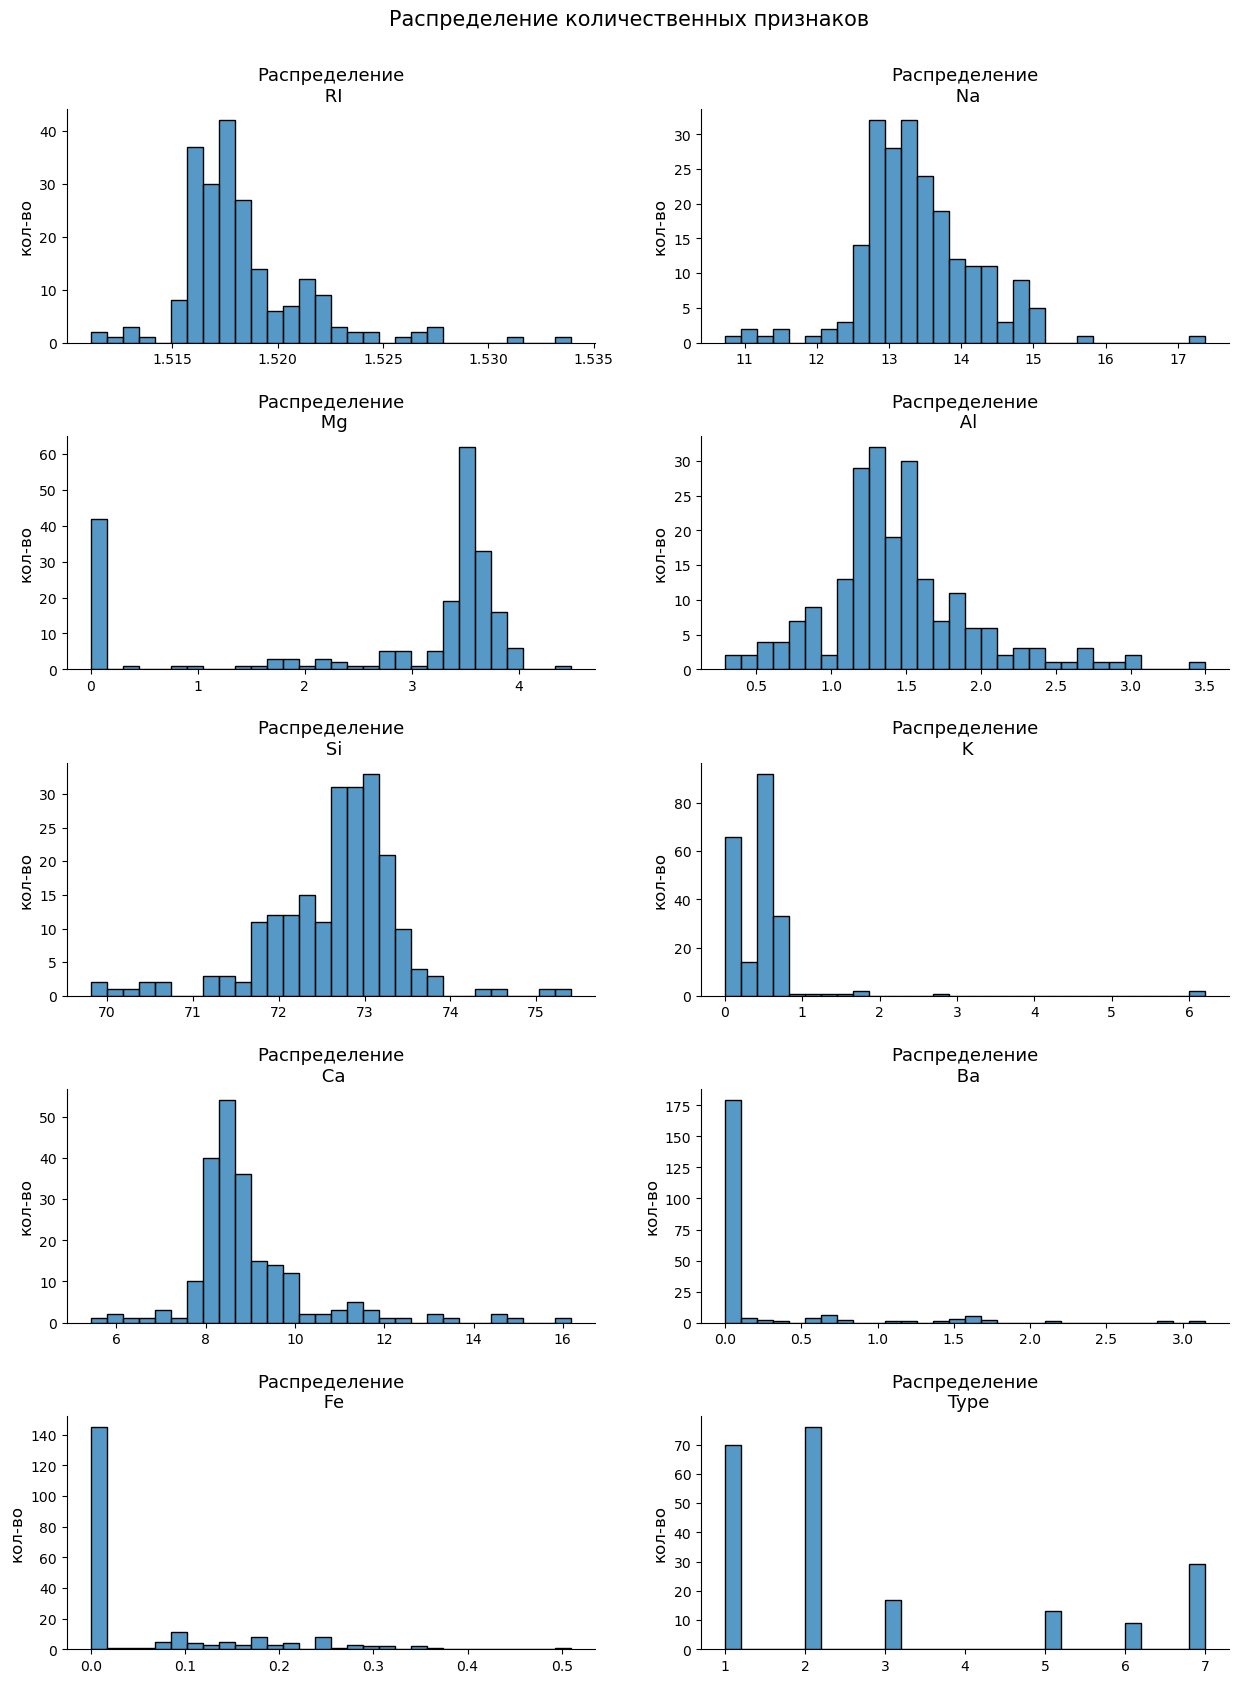

In [14]:
fig = plt.figure(figsize=(15,20))
cols = numeric
for i,col in enumerate(cols):
    fig.add_subplot(5, 2, i+1)
    sns.histplot(data=glass_raw, x=col, kde=False, bins=30)
    plt.title(f'Распределение\n {col}', size=13)
    plt.xlabel('', size=12)
    sns.despine()
    plt.ylabel('кол-во', size=12)
plt.suptitle('Распределение количественных признаков', size=15, y=0.93)
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.show()

Данные распределены в основном не нормально:  
1. По __Барию__ и __Железу__ признаки с в основном нулевые с тяжелыми хвостами - там выбросы
2. __Алюминий__ и __Кремний__ распределены нормально. 
3. __Магний__ распределен бимодально с двумя пиками в 0 и 3.5
4. __RI__ и __Натрий__ распределены похожим образом - со слегка утяжеленными хвостами, но разброс не самый большой
5. __Кремний__ распределен примерно так же, но с утяжеленной головой  

Выбросы будем находить с помощью разделяющего леса. Потестируем как он работает на одном столбце. 
1. По инструкции задаем процент данных , которые собираемся обнаружить.  
2. В предсказании получим вектор где выбросы будут помечены как -1
3. В цикле пройдемся по всем столбцам. Для каждого обучим модель
4. Рассчитаем уровень аномальности в соответствии с процентом 
5. Соберем новый датафрейм где анамальные значения заменим на `nan`
6. Оценим потери данных
7. Заменим пропуски медианой по столбцу

In [15]:
model = IsolationForest(contamination=0.01, random_state=1)
model.fit(glass_raw['RI'].values.reshape(-1,1))
raw_values = np.array(glass_raw['RI'])
xx = np.linspace(glass_raw['RI'].min(), glass_raw['RI'].max(), len(glass_raw)).reshape(-1,1)
outlier = model.predict(xx)
sample(list(zip(raw_values, outlier)), 15)

[(1.51618, 1),
 (1.51832, 1),
 (1.51783, 1),
 (1.51761, 1),
 (1.52227, 1),
 (1.51847, 1),
 (1.52099, 1),
 (1.51596, 1),
 (1.51662, 1),
 (1.51753, 1),
 (1.5232, 1),
 (1.52667, 1),
 (1.51838, -1),
 (1.51709, 1),
 (1.5167, 1)]

,cnt,%
RI,42,19.630
Na,57,26.640
Mg,37,17.290
Al,26,12.150
Si,12,5.610
K,123,57.480
Ca,31,14.490
Ba,66,30.840
Fe,62,28.970


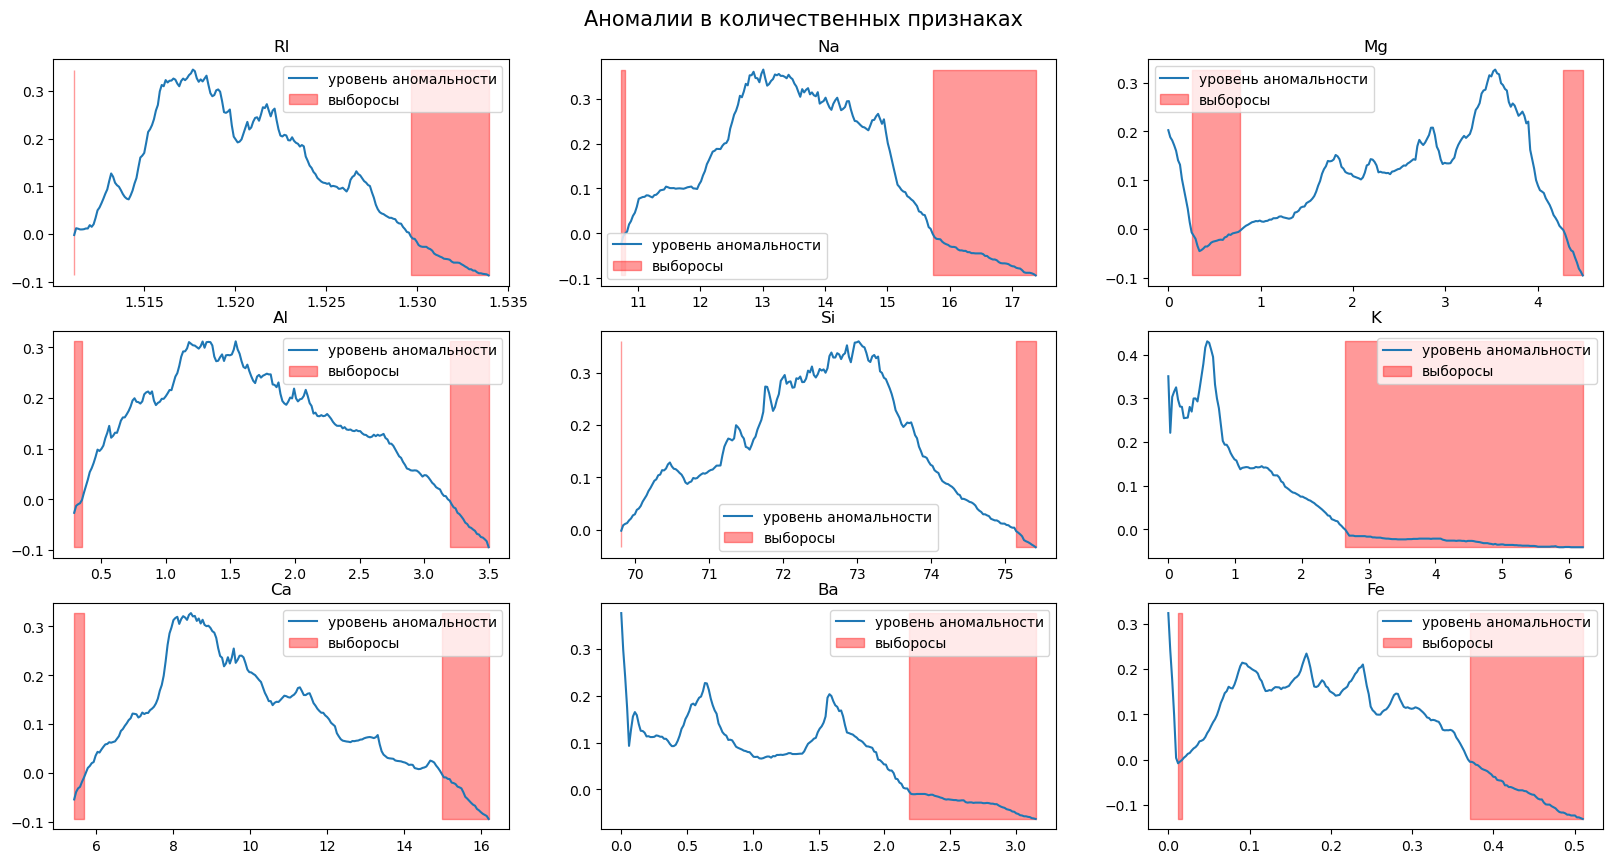

In [16]:
glass_if = pd.DataFrame()

cols = ['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']
fig, axs = plt.subplots(3, 3, figsize=(20, 10), facecolor='w', edgecolor='k')
axs = axs.ravel()
for i, column in enumerate(cols):

    model = IsolationForest(contamination=0.01, random_state=1)
    model.fit(glass_raw[column].values.reshape(-1,1))

    xx = np.linspace(glass_raw[column].min(), glass_raw[column].max(), len(glass_raw)).reshape(-1,1)

    anomaly_score = model.decision_function(xx)
    outlier = model.predict(xx)
    
    axs[i].plot(xx, anomaly_score, label='уровень аномальности')
    axs[i].fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                     where=outlier==-1, color='r', 
                     alpha=.4, label='выборосы')
    axs[i].legend()
    axs[i].set_title(column)
        
    glass_if[column] = glass_raw[column] * np.where(outlier > 0, outlier, np.nan)
    plt.suptitle('Аномалии в количественных признаках', size=15, y=0.93)


display(pd.concat([glass_if.isnull().sum().rename('cnt'), round((glass_if.isna().mean() * 100),2).rename('%')], axis=1))
glass_if['Type'] = glass_raw['Type']
glass_if.fillna(glass_if.median(axis=0), inplace=True)

Похоже все удалилось корректно. В __Калии__ удалено больше половины закрашенных розорым цветом выбросов. В __Кремнии__ и __Алюминии__ меньше всего

In [17]:
glass_if.head(10)

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.518,13.200,4.490,1.335,72.760,0.060,8.600,0.000,0.000,1
1,1.518,13.200,3.600,1.335,72.730,0.480,8.600,0.000,0.000,1
2,1.516,13.200,3.550,1.335,72.990,0.390,8.600,0.000,0.000,1
3,1.518,13.210,3.690,1.335,72.610,0.570,8.600,0.000,0.000,1
4,1.517,13.270,3.620,1.335,73.080,0.550,8.600,0.000,0.000,1
5,1.516,12.790,3.610,1.620,72.970,0.640,8.600,0.000,0.000,1
6,1.517,13.300,3.600,1.140,73.090,0.580,8.170,0.000,0.000,1
7,1.518,13.150,3.610,1.050,73.240,0.570,8.240,0.000,0.000,1
8,1.519,14.040,3.580,1.370,72.080,0.560,8.300,0.000,0.000,1
9,1.518,13.000,3.600,1.360,72.990,0.570,8.400,0.000,0.110,1


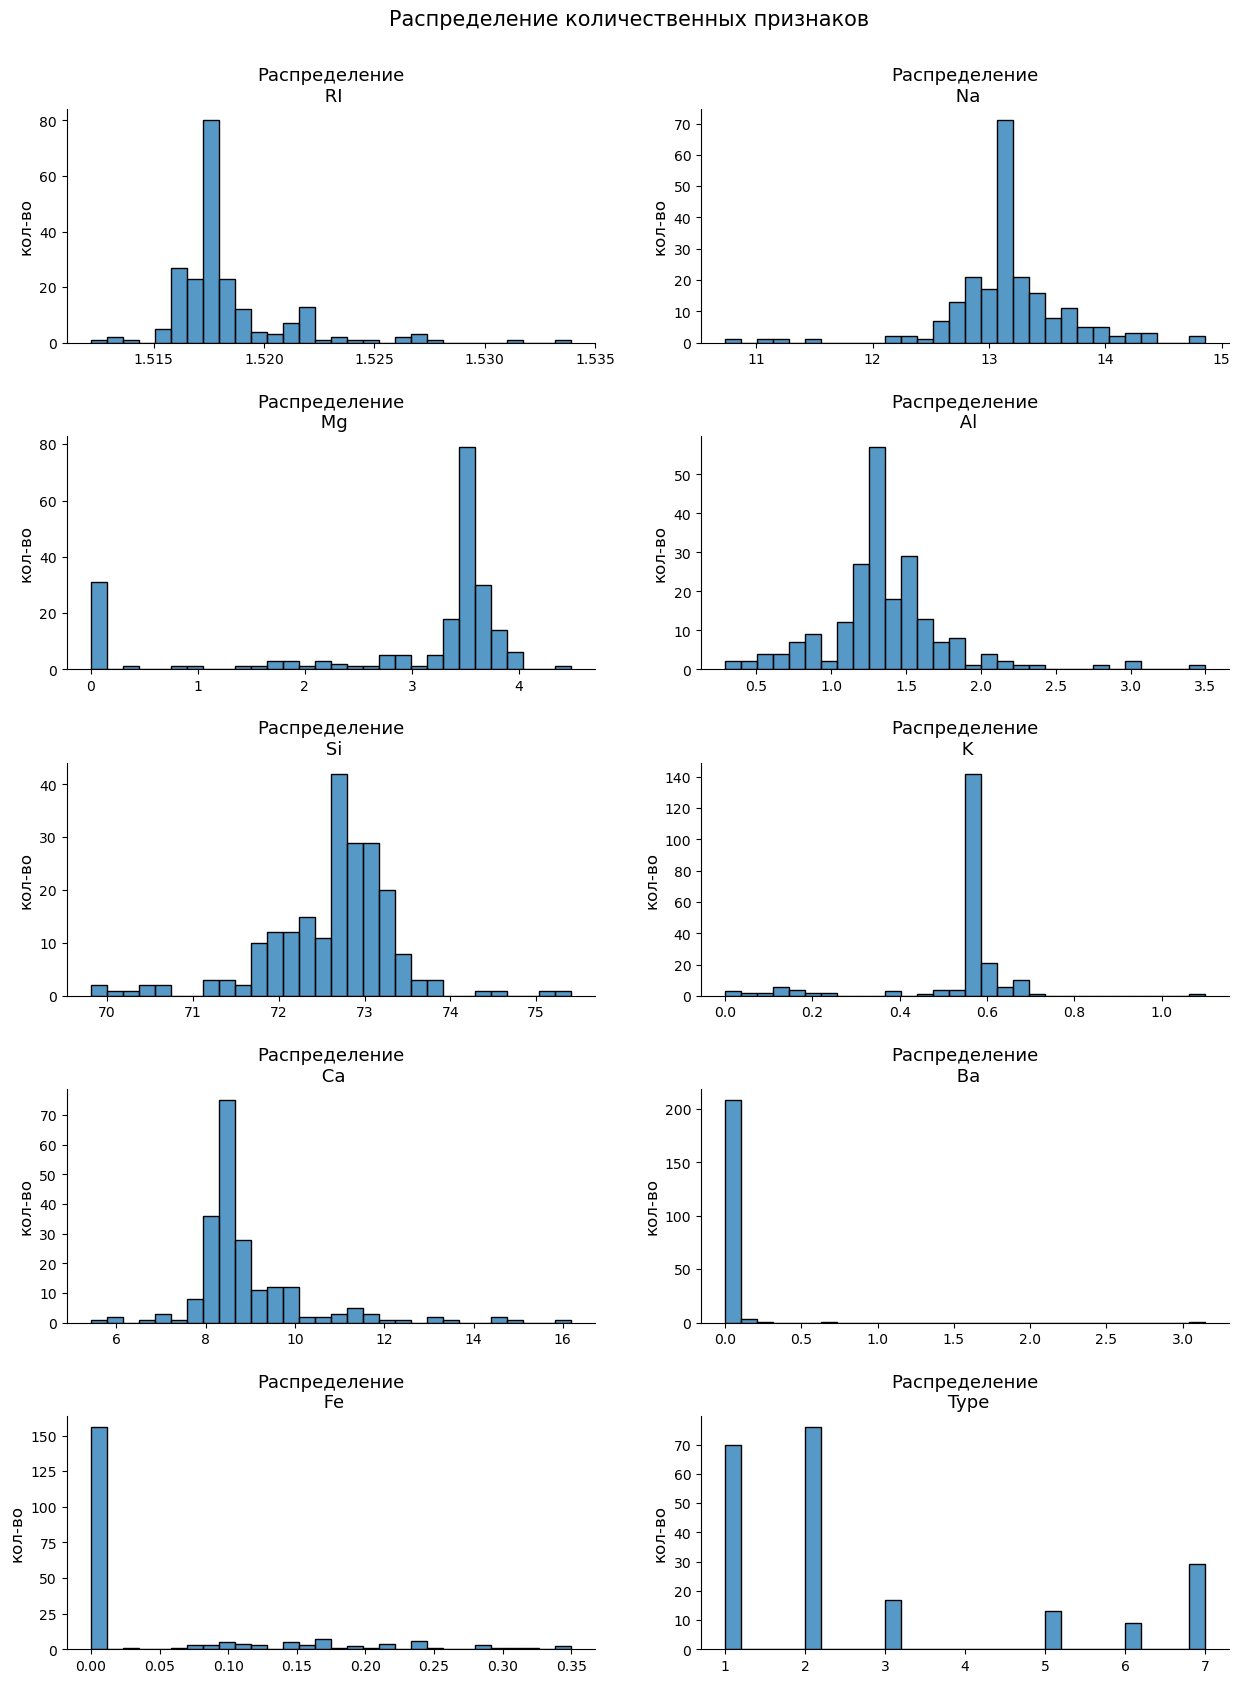

In [18]:
fig = plt.figure(figsize=(15,20))
cols = numeric
for i,col in enumerate(cols):
    fig.add_subplot(5, 2, i+1)
    sns.histplot(data=glass_if, x=col, kde=False, bins=30)
    plt.title(f'Распределение\n {col}', size=13)
    plt.xlabel('', size=12)
    sns.despine()
    plt.ylabel('кол-во', size=12)
plt.suptitle('Распределение количественных признаков', size=15, y=0.93)
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.show()

In [19]:
glass_if.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000,214.000,214.000,214.000,214.000,214.000,214.000,214.000,214.000,214.000
mean,1.518,13.187,2.853,1.362,72.637,0.534,8.964,0.022,0.047,2.780
std,0.003,0.504,1.301,0.416,0.763,0.147,1.406,0.221,0.087,2.104
min,1.512,10.730,0.000,0.290,69.810,0.000,5.430,0.000,0.000,1.000
5%,1.516,12.566,0.000,0.696,71.315,0.127,7.873,0.000,0.000,1.000
25%,1.517,12.990,2.817,1.190,72.290,0.570,8.312,0.000,0.000,1.000
50%,1.518,13.200,3.470,1.335,72.760,0.570,8.600,0.000,0.000,2.000
75%,1.519,13.360,3.580,1.540,73.047,0.570,9.138,0.000,0.077,3.000
95%,1.523,14.004,3.843,2.067,73.487,0.663,11.561,0.000,0.240,7.000
max,1.534,14.860,4.490,3.500,75.410,1.100,16.190,3.150,0.350,7.000


In [20]:
res_1 = get_score_df(glass_if, 'Type', model=RandomForestClassifier(
    n_estimators=40,
    max_features=9,
    max_samples=.5,
    class_weight='balanced',
    random_state=1), title='rfc_IsolationForest')
res = pd.concat([res, res_1], axis=1)
res.T

,accuracy_train,accuracy_test
rfc_raw,0.959,0.814
rfc_IsolationForest,0.971,0.837


Метрика на тесте слегка увеличилась, но она так же увеличилась на обучении. Модель все еще переучивается

Попробуем избавиться от выбросов статистически: 
1. Отбросим значения ниже 5 и выше 95 персентилей. 
2. Оценим потери. 
3. Появившиеся пропуски заменим медианой по каждому признаку

In [21]:
glass_stat = glass_raw.copy()

for column in glass_raw.iloc[:,:-1].columns:
    q_low = glass_raw[column].quantile(0.05) 
    q_up = glass_raw[column].quantile(0.95)
    glass_stat[column] = glass_raw.loc[(glass_raw[column] > q_low) & (glass_raw[column] < q_up)][column]
display(pd.concat([glass_stat.isnull().sum().rename('cnt'), round((glass_stat.isna().mean() * 100),2).rename('%')], axis=1))
glass_stat['Type'] = glass_raw['Type']
glass_stat.fillna(glass_stat.median(axis=0), inplace=True)

,cnt,%
RI,22,10.280
Na,22,10.280
Mg,54,25.230
Al,22,10.280
Si,22,10.280
K,42,19.630
Ca,22,10.280
Ba,188,87.850
Fe,155,72.430
Type,0,0.000


In [22]:
glass_stat.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000,214.000,214.000,214.000,214.000,214.000,214.000,214.000,214.000,214.000
mean,1.518,13.393,3.351,1.414,72.697,0.486,8.803,0.582,0.141,2.780
std,0.002,0.535,0.546,0.325,0.471,0.189,0.759,0.139,0.033,2.104
min,1.515,12.450,0.330,0.710,71.350,0.020,7.830,0.060,0.010,1.000
5%,1.516,12.686,2.016,0.870,71.776,0.080,7.970,0.537,0.090,1.000
25%,1.517,13.000,3.442,1.230,72.392,0.472,8.342,0.585,0.140,1.000
50%,1.518,13.300,3.520,1.360,72.790,0.560,8.600,0.585,0.140,2.000
75%,1.519,13.697,3.580,1.560,73.020,0.600,9.015,0.585,0.140,3.000
95%,1.522,14.394,3.744,2.067,73.294,0.673,10.306,0.633,0.220,7.000
max,1.524,14.850,3.840,2.380,73.500,0.730,11.530,1.550,0.260,7.000


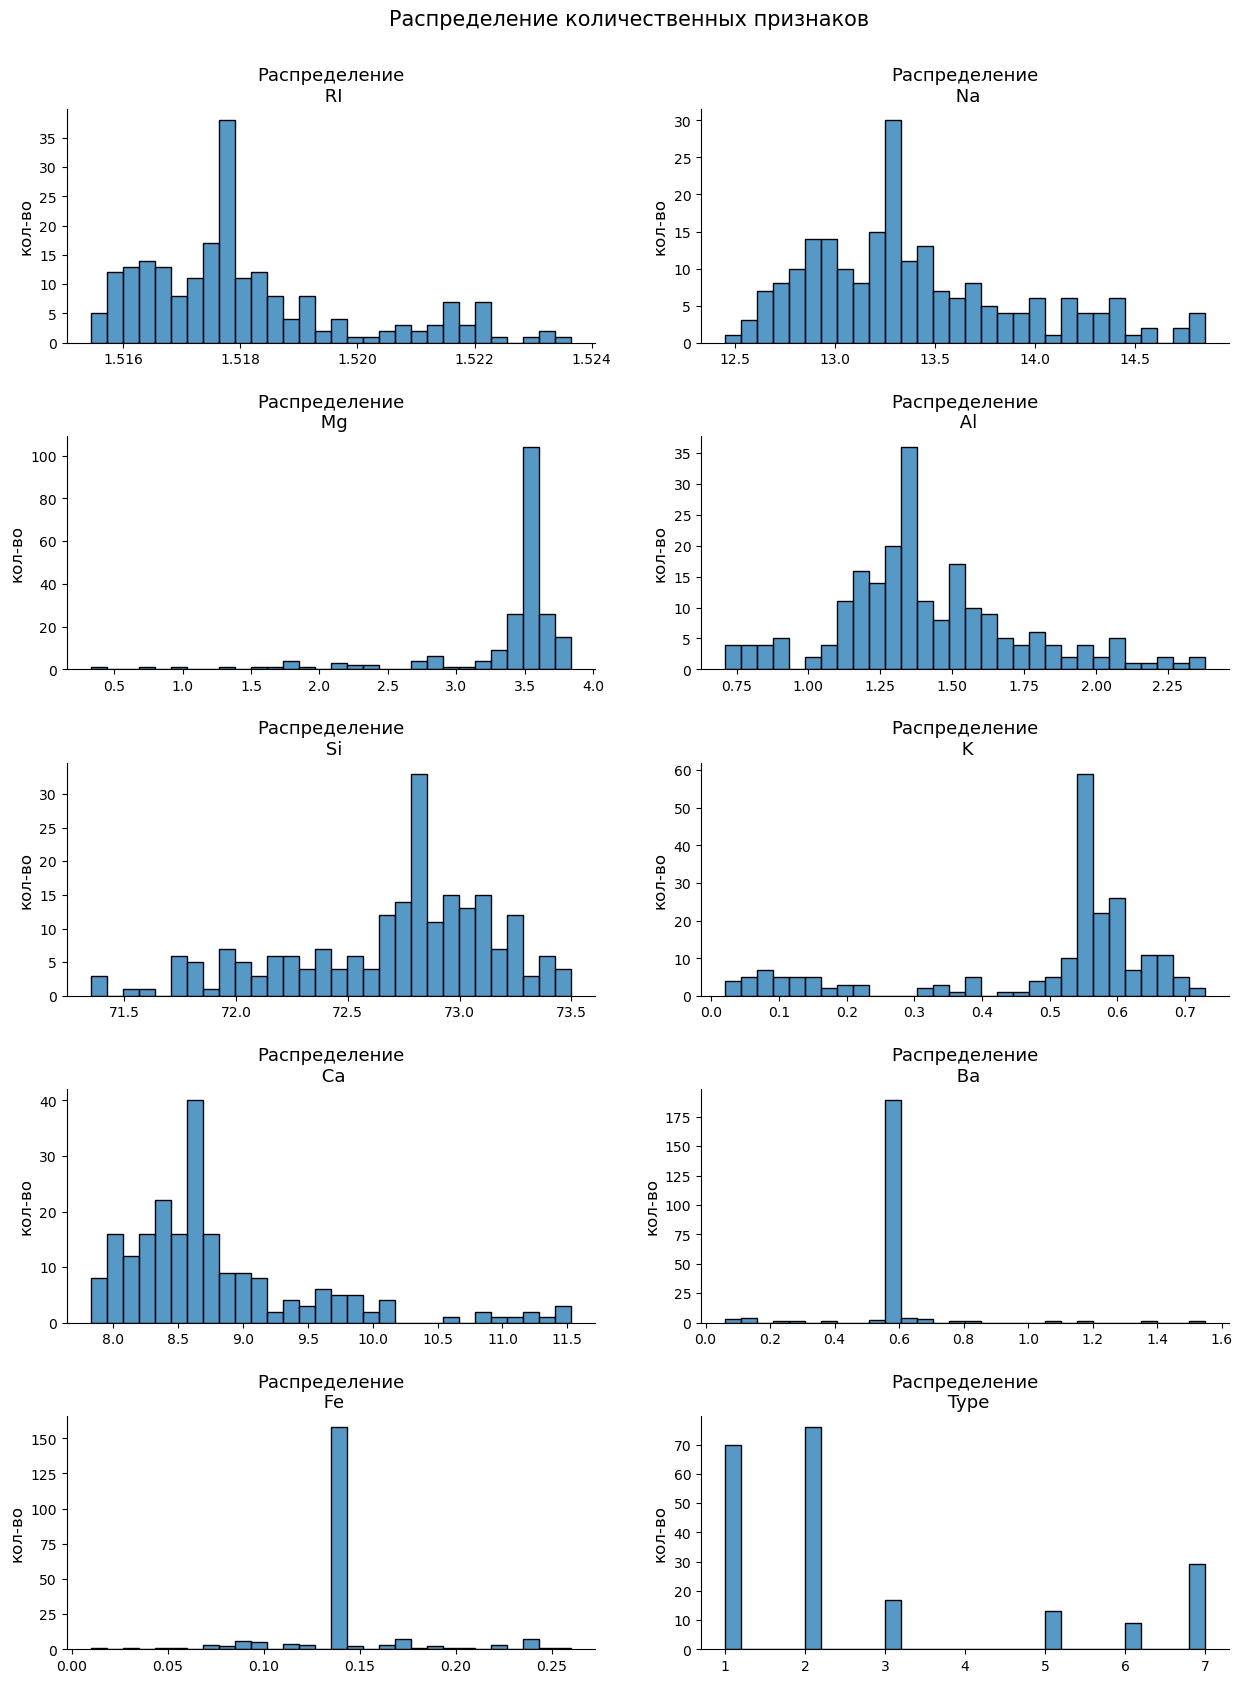

In [23]:
fig = plt.figure(figsize=(15,20))
cols = numeric
for i,col in enumerate(cols):
    fig.add_subplot(5, 2, i+1)
    sns.histplot(data=glass_stat, x=col, kde=False, bins=30)
    plt.title(f'Распределение\n {col}', size=13)
    plt.xlabel('', size=12)
    sns.despine()
    plt.ylabel('кол-во', size=12)
plt.suptitle('Распределение количественных признаков', size=15, y=0.93)
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.show()

In [24]:
res_2 = get_score_df(glass_stat, 'Type', model=RandomForestClassifier(
    n_estimators=40,
    max_features=9,
    max_samples=.5,
    class_weight='balanced',
    random_state=1), title='rfc_stat')
res = pd.concat([res, res_2], axis=1)
res.T

,accuracy_train,accuracy_test
rfc_raw,0.959,0.814
rfc_IsolationForest,0.971,0.837
rfc_stat,0.959,0.744


#### Вывод:  
Уже на протяжении третьей работы после удаления выбросов метрики либо ухудшаются либо модели переучиваются либо и то и другое.  Напрашивается вывод

<center> <h1> !!! Выбросы лучше не удалять !!! </h1> </center>

Прошу в комментарии к дз написать что я делаю не так. Пожалуйста